# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [162]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [163]:
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

### Variables

In [164]:
print_errors = False
build_new_dataset = False
symbols = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [165]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [166]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['1 Year Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    le = LabelEncoder()
    for non_numeric_column in ['Sector', 'Industry']:
        df[non_numeric_column] = df[non_numeric_column].astype(str)
        le.fit(df[non_numeric_column])
        df[non_numeric_column] = le.transform(df[non_numeric_column])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [167]:
df

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2024-12-31,NaN,0,5,-0.018387,0.062076,0.060639,-0.062073,0.059042,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
1,AA,2023-12-31,0.103476,0,5,-0.019024,0.071720,0.060733,-0.062051,0.058705,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
2,AA,2022-12-31,-0.261057,0,5,-0.018298,0.049465,0.060754,-0.062084,0.058752,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
3,AA,2021-12-31,-0.226370,0,5,-0.018123,0.065043,0.060373,-0.061954,0.058836,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
4,AA,2020-12-31,1.590461,0,5,-0.018458,0.062076,0.060625,-0.062040,0.058834,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,ZUMZ,2025-01-31,NaN,2,7,-0.018569,0.071720,0.060755,-0.062085,0.059196,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5221,ZUMZ,2024-01-31,-0.050670,2,7,-0.018620,0.071720,0.060740,-0.062072,0.059181,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5222,ZUMZ,2023-01-31,-0.335269,2,7,-0.018639,0.067809,0.060748,-0.062079,0.059176,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5223,ZUMZ,2022-01-31,-0.425362,2,7,-0.018505,0.063094,0.060755,-0.062085,0.059186,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting

In [168]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

test_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    test_data = pd.concat([test_data, df.iloc[[1+i*5]]])  
print('Test Data:')
display(test_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Training Data:')
display(train_data)

Prediction Data:


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2024-12-31,NaN,0,5,-0.018387,6.207588e-02,0.060639,-0.062073,5.904247e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5,AAT,2024-12-31,NaN,8,94,-0.018595,-1.061186e-17,0.060725,-0.062085,5.918234e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
10,ABM,2025-01-31,NaN,7,120,-0.018729,7.077153e-02,0.060644,-0.061931,5.918463e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
15,ABR,2024-12-31,NaN,8,98,-0.018572,7.171958e-02,0.059827,-0.061347,1.424350e-17,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
20,ABT,2024-12-31,NaN,6,74,-0.016621,5.769913e-02,0.060566,-0.062084,5.852813e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,XRAY,2024-12-31,NaN,6,76,-0.018582,7.171958e-02,0.060731,-0.062110,5.915262e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5205,YORW,2024-12-31,NaN,11,139,-0.018620,-1.061186e-17,0.060752,-0.062081,5.918552e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5210,Z,2024-12-31,NaN,1,66,-0.018540,7.171958e-02,0.060608,-0.062085,5.916195e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5215,ZBRA,2024-12-31,NaN,9,24,-0.018348,7.033979e-02,0.060755,-0.062085,5.918342e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0


Test Data:


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
1,AA,2023-12-31,0.103476,0,5,-0.019024,7.171958e-02,0.060733,-0.062051,5.870455e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
6,AAT,2023-12-31,0.202075,8,94,-0.018517,-1.061186e-17,0.060700,-0.062025,5.912276e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
11,ABM,2023-10-31,0.390644,7,120,-0.018438,6.557284e-02,0.060419,-0.061773,5.915112e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
16,ABR,2023-12-31,-0.023103,8,98,-0.018396,7.005355e-02,0.057565,-0.059640,1.424350e-17,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
21,ABT,2023-12-31,0.062362,6,74,-0.013918,1.710659e-02,0.060019,-0.062084,5.714474e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201,XRAY,2023-12-31,-0.453962,6,76,-0.018404,5.836677e-02,0.060753,-0.062085,5.906114e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5206,YORW,2023-12-31,-0.142838,11,139,-0.018646,-1.061186e-17,0.060736,-0.062057,5.913930e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5211,Z,2023-12-31,0.294478,1,66,-0.018440,5.284761e-02,0.060738,-0.062070,5.904620e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5216,ZBRA,2023-12-31,0.413002,9,24,-0.018700,6.940509e-02,0.060682,-0.061968,5.911901e-02,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0


Training Data:


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
2,AA,2022-12-31,-0.261057,0,5,-0.018298,4.946490e-02,0.060754,-0.062084,0.058752,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
3,AA,2021-12-31,-0.226370,0,5,-0.018123,6.504318e-02,0.060373,-0.061954,0.058836,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
4,AA,2020-12-31,1.590461,0,5,-0.018458,6.207588e-02,0.060625,-0.062040,0.058834,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
7,AAT,2022-12-31,-0.100890,8,94,-0.018555,-1.061186e-17,0.060722,-0.062055,0.059094,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
8,AAT,2021-12-31,-0.263050,8,94,-0.018556,-1.061186e-17,0.060679,-0.061954,0.059103,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,ZBRA,2021-12-31,-0.570891,9,24,-0.017678,6.918255e-02,0.060665,-0.062072,0.059145,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5219,ZBRA,2020-12-31,0.548669,9,24,-0.018239,6.180512e-02,0.060696,-0.061968,0.059144,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5222,ZUMZ,2023-01-31,-0.335269,2,7,-0.018639,6.780899e-02,0.060748,-0.062079,0.059176,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0
5223,ZUMZ,2022-01-31,-0.425362,2,7,-0.018505,6.309415e-02,0.060755,-0.062085,0.059186,...,1.042401e-15,0.0,0.0,-6.365565e-16,0.0,0.0,0.0,0.0,0.0,0.0


### Labeling

In [169]:
X_pred = pred_data.drop(['Ticker', 'Date', '1 Year Future Change'], axis=1)
X_test = test_data.drop(['Ticker', 'Date', '1 Year Future Change'], axis=1)
y_test = test_data['1 Year Future Change']
X_train = train_data.drop(['Ticker', 'Date', '1 Year Future Change'], axis=1)
y_train = train_data['1 Year Future Change']

## Model Training

In [ ]:
model = MLPRegressor(
    verbose=True,
    shuffle=True,
    solver='adam',
    learning_rate='adaptive',
    batch_size='auto',
    alpha=1e-4,
    hidden_layer_sizes=(10, 10, 10, 10, 10),
    random_state=42,
    tol=0.0001,
    max_iter=500,
    n_iter_no_change=4
)
model.fit(X_train, y_train)

Iteration 1, loss = 0.14174124
Iteration 2, loss = 0.12440152
Iteration 3, loss = 0.11993248
Iteration 4, loss = 0.11896736
Iteration 5, loss = 0.11836001
Iteration 6, loss = 0.11749284
Iteration 7, loss = 0.11718739
Iteration 8, loss = 0.11704105
Iteration 9, loss = 0.11677838
Iteration 10, loss = 0.11638546
Iteration 11, loss = 0.11640336
Iteration 12, loss = 0.11586498
Iteration 13, loss = 0.11582302
Iteration 14, loss = 0.11520693
Iteration 15, loss = 0.11535285
Iteration 16, loss = 0.11519729
Iteration 17, loss = 0.11528725
Iteration 18, loss = 0.11529688
Iteration 19, loss = 0.11462670
Iteration 20, loss = 0.11495918
Iteration 21, loss = 0.11420015
Iteration 22, loss = 0.11410007
Iteration 23, loss = 0.11406920
Iteration 24, loss = 0.11384009
Iteration 25, loss = 0.11356277
Iteration 26, loss = 0.11324923
Iteration 27, loss = 0.11294004
Iteration 28, loss = 0.11418865
Iteration 29, loss = 0.11256913
Iteration 30, loss = 0.11269659
Iteration 31, loss = 0.11262160
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10, 10),
             learning_rate='adaptive', max_iter=500, n_iter_no_change=4,
             random_state=42, verbose=True)

## Testing and benchmarking

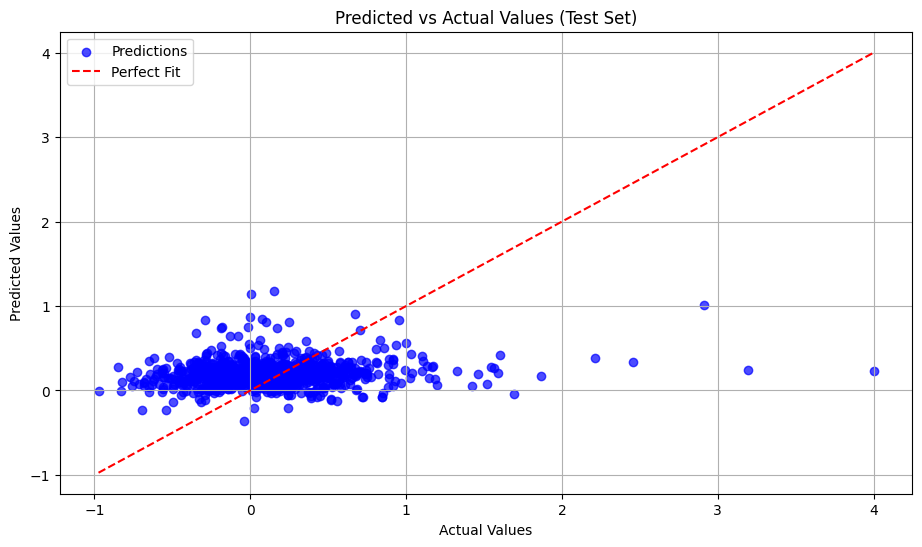

MAE: 0.3205
MSE: 0.1929
R²: -0.0594


In [177]:
y_test_pred = model.predict(X_test)

plt.figure(figsize=(11, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

No random_test_split, learning_rate = adaptive
* -2.6308 (10)
* -0.1810 (10, 10)
* -0.0870 (10, 10, 10)
* -0.0597 (10, 10, 10, 10)
* -0.0467 (10, 10, 10, 10, 10)

## Predictions on latest data